In [1]:
# from keras import backend as K
# from keras.objectives import mse
# from keras.optimizers import Adam
# from keras.layers import Dense, Lambda, Input
# from keras.models import Model

import matplotlib.pyplot as plt

from pyspark.ml.linalg import Vectors
from pyspark.sql.types import FloatType

In [2]:
from functools import reduce
from itertools import islice
import math
import pickle

import tensorflow as tf
import numpy as np

from hyperspherical_vae.distributions import VonMisesFisher, HypersphericalUniform

class VariationalAutoEncoder(object):
    def __init__(self, n_input_units, n_hidden_layers, n_hidden_units, n_latent_units,
                 learning_rate=0.005, batch_size=100, min_beta=1.0, max_beta=1.0,
                 distribution='normal'):
        self.n_input_units = n_input_units
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_latent_units = n_latent_units
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.distribution = distribution

    class Encoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units, distribution):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_latent_units = n_latent_units
            self.distribution = distribution

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_mu(self, inputs):
            if self.distribution == 'normal':
                self.mu = tf.layers.Dense(units=self.n_latent_units)
            elif self.distribution == 'vmf':
                self.mu = tf.layers.Dense(units=self.n_latent_units, 
                                          activation=lambda x: tf.nn.l2_normalize(x, axis=-1))
            else:
                raise NotImplemented
                
            self.applied_mu = self.mu.apply(inputs)
            return self.applied_mu

        def add_sigma(self, inputs):
            if self.distribution == 'normal':
                self.sigma = tf.layers.Dense(units=self.n_latent_units)
                self.applied_sigma = self.sigma.apply(inputs)
            elif self.distribution == 'vmf':
                self.sigma = tf.layers.Dense(units=1, activation=tf.nn.softplus)
                self.applied_sigma = self.sigma.apply(inputs) + 1
            else:
                raise NotImplemented
            return self.applied_sigma

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            mu = self.add_mu(layer)
            sigma = self.add_sigma(layer)

            return mu, sigma

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            mu = sess.run([self.mu.kernel, self.mu.bias])

            sigma = sess.run([self.sigma.kernel, self.sigma.bias])

            return layers, mu, sigma

    class Decoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_output_units):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_output_units = n_output_units

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_output(self, inputs):
            self.output = tf.layers.Dense(units=self.n_output_units)
            self.applied_output = self.output.apply(inputs)
            return self.applied_output

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            output = self.add_output(layer)

            return output

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            output = sess.run([self.output.kernel, self.output.bias])

            return layers, output

    def sampled_z(self, mu, sigma, batch_size):
        if self.distribution == 'normal':
            epsilon = tf.random_normal(tf.stack([int(batch_size), self.n_latent_units]))
            z = mu + tf.multiply(epsilon, tf.exp(0.5 * sigma))
            loss = -0.5 * self.beta * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), 1)
        elif self.distribution == 'vmf':
            self.q_z = VonMisesFisher(mu, sigma, validate_args=True, allow_nan_stats=False)
            z = self.q_z.sample()
            self.p_z = HypersphericalUniform(self.n_latent_units - 1, validate_args=True, allow_nan_stats=False)
            loss = self.q_z.kl_divergence(self.p_z)
        else:
            raise NotImplemented

        return z, loss

    def build_feature_loss(self, x, output):
        return tf.reduce_sum(tf.squared_difference(x, output), 1)

    def initialize_tensors(self):
        self.x = tf.placeholder("float32", [self.batch_size, self.n_input_units])
        self.beta = tf.placeholder("float32", [1, 1])
        self.encoder = self.Encoder(self.n_hidden_layers, self.n_hidden_units, self.n_latent_units, 
                                    self.distribution)
        mu, sigma = self.encoder.build(self.x)
        self.mu = mu
        self.sigma = sigma
        
        z, latent_loss = self.sampled_z(self.mu, self.sigma, self.batch_size)
        self.z = z
        self.latent_loss = latent_loss
        
        self.decoder = self.Decoder(self.n_hidden_layers, self.n_hidden_units, self.n_input_units)
        self.output = self.decoder.build(self.z)
        
        self.feature_loss = self.build_feature_loss(self.x, self.output)
        self.loss = tf.reduce_mean(self.feature_loss + self.latent_loss)
        

    def generate_beta_values(self, data_count, epochs):
        num_batches = int(data_count / self.batch_size)
        total_steps = (num_batches * epochs) - epochs
        beta_delta = self.max_beta - self.min_beta
        log_beta_step = 5 / float(total_steps)
        beta_values = [
            self.min_beta + (beta_delta * (1 - math.exp(-5 + (i * log_beta_step))))
            for i in range(total_steps)
        ]
        return beta_values

    def train_from_rdd(self, data_rdd, epochs=1):
        self.initialize_tensors()

        data_count = data_rdd.count()
        beta_values = self.generate_beta_values(data_count, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_index in range(epochs):
                iterator = data_rdd.toLocalIterator()
                batch_index = 0
                while True:
                    batch = np.array(list(islice(iterator, self.batch_size)))
                    if batch.shape[0] == self.batch_size:
                        beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                        feed_dict = {self.x: np.array(batch), self.beta: np.array([[beta]])}

                        if not batch_index % 100:
                            print("beta: {}".format(beta))
                            ls, f_ls, d_ls = sess.run([self.loss, self.feature_loss, self.latent_loss],
                                                      feed_dict=feed_dict)
                            print("loss={}, avg_feature_loss={}, avg_latent_loss={}".format(ls, np.mean(f_ls),
                                                                                            np.mean(d_ls)))
                            print('running batch {} in epoch {}'.format(batch_index, epoch_index))
                        sess.run(optimizer, feed_dict=feed_dict)
                        batch_index += 1
                    else:
                        print("incomplete batch: {}".format(batch.shape))
                        break

            print("evaluating model...")
            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)

    def train(self, data, visualize=False, epochs=1):
        self.initialize_tensors()
        
        data_size = data.shape[0]
        batch_size = self.batch_size
        beta_values = self.generate_beta_values(data_size, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            i = 0
            while (i * batch_size) < data_size:
                batch = data[i * batch_size:(i + 1) * batch_size]
                beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                feed_dict = {self.x: batch, self.beta: np.array([[beta]])}
                sess.run(optimizer, feed_dict=feed_dict)
                if visualize and (not i % int((data_size / batch_size) / 3) or i == int(data_size / batch_size) - 1):
                    ls, d, f_ls, d_ls = sess.run([self.loss, self.output, self.feature_loss, self.latent_loss],
                                                 feed_dict=feed_dict)
                    plt.scatter(batch[:, 0], batch[:, 1])
                    plt.show()
                    plt.scatter(d[:, 0], d[:, 1])
                    plt.show()
                    print(i, ls, np.mean(f_ls), np.mean(d_ls))

                i += 1

            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)


class VariationalAutoEncoderModel(object):
    def __init__(self, encoder_layers, mu, sigma, decoder_layers, output):
        self.encoder = self.EncoderModel(encoder_layers, mu, sigma)
        self.decoder = self.DecoderModel(decoder_layers, output)

    def save(self, path):
        encoder_layers, encoder_mu, encoder_sigma = self.encoder.dump()
        decoder_layers, decoder_output = self.decoder.dump()
        serializable_model = (encoder_layers, encoder_mu, encoder_sigma, decoder_layers, decoder_output)
        pickle.dump(serializable_model, open(path, 'w+'))

    def encode(self, x):
        return self.encoder.encode(x)

    def project(self, x):
        return self.encoder.encode(x)[0]

    def decode(self, x):
        return self.decoder.decode(x)

    @classmethod
    def load(cls, path):
        return cls(*pickle.load(open(path, 'r')))

    class Layer(object):
        def __init__(self, kernel, bias, activation='linear'):
            self.kernel = kernel
            self.bias = bias
            self.activation = activation

        def dump(self):
            return (self.kernel, self.bias, self.activation)

        @property
        def apply_func(self):
            kernel, bias = self.kernel, self.bias

            linear = lambda inputs: np.matmul(inputs, kernel) + bias

            if self.activation == 'linear':
                f = linear
            elif self.activation == 'sigmoid':
                f = lambda inputs: 1 / (1 + np.exp(-linear(inputs)))

            return f

        def apply(self, inputs):
            return self.apply_func(inputs)

    class EncoderModel(object):
        def __init__(self, encoder_layers, mu, sigma):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in encoder_layers
            ]
            self.mu = VariationalAutoEncoderModel.Layer(*mu)
            self.sigma = VariationalAutoEncoderModel.Layer(*sigma)

        def dump(self):
            encoder_layers = [l.dump()[:2] for l in self.layers]
            encoder_mu = self.mu.dump()[:2]
            encoder_sigma = self.sigma.dump()[:2]
            return encoder_layers, encoder_mu, encoder_sigma

        def encode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.mu.apply(x), self.sigma.apply(x)

    class DecoderModel(object):
        def __init__(self, decoder_layers, output):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in decoder_layers
            ]
            self.output = VariationalAutoEncoderModel.Layer(*output)

        def dump(self):
            decoder_layers = [l.dump()[:2] for l in self.layers]
            decoder_output = self.output.dump()[:2]
            return decoder_layers, decoder_output

        def decode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.output.apply(x)

In [3]:
acxiom_df = spark.read.parquet("/dbfs/mnt/ddda/ml-bme-scoring/tmp/learningday_july9/acxiom_segment").persist()

In [4]:
from pyspark.ml.feature import VectorAssembler

all_columns_without_cid = acxiom_df.columns[:]
all_columns_without_cid.remove('customer_id')
assembler = VectorAssembler(inputCols=all_columns_without_cid, outputCol='features')
vec_df = assembler.transform(acxiom_df).rdd.map(lambda r: r.features.toArray()).persist()

In [5]:
# For example, train a model like so:

model = VariationalAutoEncoder(n_input_units=len(all_columns_without_cid), n_hidden_layers=2, 
                               n_hidden_units=493, n_latent_units=1, 
                               learning_rate=0.005, batch_size=100, 
                               min_beta=0.01, max_beta=0.1, distribution='normal')\
    .train_from_rdd(vec_df, epochs=2)

beta: 0.09939358477008231
loss=5607.98876953125, avg_feature_loss=5607.91796875, avg_latent_loss=0.07105191051959991
running batch 0 in epoch 0
beta: 0.09939171311962161
loss=829.3583374023438, avg_feature_loss=825.2938842773438, avg_latent_loss=4.064517498016357
running batch 100 in epoch 0
beta: 0.09938983569246654
loss=929.0733642578125, avg_feature_loss=926.800048828125, avg_latent_loss=2.2731881141662598
running batch 200 in epoch 0
beta: 0.09938795247078779
loss=813.2845458984375, avg_feature_loss=808.1021728515625, avg_latent_loss=5.182384014129639
running batch 300 in epoch 0
beta: 0.09938606343670107
loss=665.3851318359375, avg_feature_loss=659.7977905273438, avg_latent_loss=5.587359428405762
running batch 400 in epoch 0
beta: 0.09938416857226684
loss=507.245361328125, avg_feature_loss=504.4390563964844, avg_latent_loss=2.8062515258789062
running batch 500 in epoch 0
beta: 0.09938226785949024
loss=634.777587890625, avg_feature_loss=632.7509765625, avg_latent_loss=2.026594400405884
running batch 600 in epoch 0
beta: 0.09938036128032084
loss=547.1231079101562, avg_feature_loss=543.2985229492188, avg_latent_loss=3.824645757675171
running batch 700 in epoch 0
beta: 0.09937844881665248
loss=569.5733032226562, avg_feature_loss=563.0645141601562, avg_latent_loss=6.508829116821289
running batch 800 in epoch 0
beta: 0.09937653045032314
loss=485.8006896972656, avg_feature_loss=484.13641357421875, avg_latent_loss=1.6642897129058838
running batch 900 in epoch 0
beta: 0.09937460616311479
loss=547.0964965820312, avg_feature_loss=544.556640625, avg_latent_loss=2.5398426055908203
running batch 1000 in epoch 0
beta: 0.09937267593675307
loss=577.81103515625, avg_feature_loss=572.7484130859375, avg_latent_loss=5.062567710876465
running batch 1100 in epoch 0
beta: 0.09937073975290732
loss=634.1900634765625, avg_feature_loss=629.4771728515625, avg_latent_loss=4.712913990020752
running batch 1200 in epoch 0
beta: 0.09936879759319024
loss=534.3768920898438, avg_feature_loss=531.71484375, avg_latent_loss=2.6621499061584473
running batch 1300 in epoch 0
beta: 0.09936684943915779
loss=532.5691528320312, avg_feature_loss=530.6283569335938, avg_latent_loss=1.9408513307571411
running batch 1400 in epoch 0
beta: 0.09936489527230902
loss=441.23809814453125, avg_feature_loss=438.0067138671875, avg_latent_loss=3.2312698364257812
running batch 1500 in epoch 0
beta: 0.09936293507408586
loss=467.71319580078125, avg_feature_loss=463.7857666015625, avg_latent_loss=3.9274392127990723
running batch 1600 in epoch 0
beta: 0.09936096882587299
loss=677.2711181640625, avg_feature_loss=675.1234130859375, avg_latent_loss=2.1476993560791016
running batch 1700 in epoch 0
beta: 0.0993589965089976
loss=499.7867126464844, avg_feature_loss=497.32452392578125, avg_latent_loss=2.462219476699829
running batch 1800 in epoch 0
beta: 0.09935701810472927
loss=405.0639953613281, avg_feature_loss=402.4110412597656, avg_latent_loss=2.6529016494750977
running batch 1900 in epoch 0
beta: 0.09935503359427977
loss=413.3293762207031, avg_feature_loss=409.2560119628906, avg_latent_loss=4.073336601257324
running batch 2000 in epoch 0
beta: 0.09935304295880287
loss=355.10394287109375, avg_feature_loss=353.0981750488281, avg_latent_loss=2.0057461261749268
running batch 2100 in epoch 0
beta: 0.09935104617939419
loss=393.44268798828125, avg_feature_loss=391.6315612792969, avg_latent_loss=1.8111835718154907
running batch 2200 in epoch 0
beta: 0.09934904323709098
loss=443.1411437988281, avg_feature_loss=441.0848388671875, avg_latent_loss=2.0563008785247803
running batch 2300 in epoch 0
beta: 0.09934703411287199
loss=441.05450439453125, avg_feature_loss=437.2169494628906, avg_latent_loss=3.8375251293182373
running batch 2400 in epoch 0
beta: 0.09934501878765722
loss=308.3763427734375, avg_feature_loss=306.5311584472656, avg_latent_loss=1.8451663255691528
running batch 2500 in epoch 0
beta: 0.09934299724230784
loss=1031.3497314453125, avg_feature_loss=1029.68701171875, avg_latent_loss=1.6625776

In [6]:
model.encoder.layers[0].__dict__


Out[ 34 ]: 
{'kernel': array([[-0.03483483, 0.03007248, -0.04911023, ..., 0.01890367,
 0.00477581, 0.06695753],
 [-0.06810383, -0.05531385, 0.00313132, ..., 0.00987785,
 -0.00476372, -0.07200421],
 [ 0.01131103, -0.02053376, -0.03117744, ..., 0.01971988,
 -0.01309029, -0.07793407],
 ...,
 [ 0.0643691 , 0.06967107, 0.03350699, ..., 0.00326344,
 -0.07068758, -0.05514351],
 [-0.02716121, -0.06617416, 0.03759897, ..., 0.04376343,
 0.04337563, -0.00626849],
 [ 0.00545701, 0.01964737, 0.04047941, ..., -0.0142002 ,
 -0.06282534, -0.06395233]], dtype=float32),
 'activation': 'sigmoid',
 'bias': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 dtype=float32)}

In [7]:
dbutils.fs.mkdirs("mnt/ddda/ml-bme-scoring/learningday_july9/")
# dbutils.fs.rm("/mnt/ddda/ml-bme-scoring/learningday_july9/model_2")
model.save("/dbfs/mnt/ddda/ml-bme-scoring/learningday_july9/model_2")

--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-1202086> in <module> () 
 1 dbutils . fs . mkdirs ( "mnt/ddda/ml-bme-scoring/learningday_july9/" ) 
 2 # dbutils.fs.rm("/mnt/ddda/ml-bme-scoring/learningday_july9/model_2") 
 ----> 3 model . save ( "/dbfs/mnt/ddda/ml-bme-scoring/learningday_july9/model_2" ) 

 <command-1202082> in save (self, path) 
 230 decoder_layers , decoder_output = self . decoder . dump ( ) 
 231 serializable_model = ( encoder_layers , encoder_mu , encoder_sigma , decoder_layers , decoder_output ) 
 --> 232 pickle . dump ( serializable_model , open ( path , 'w+' ) ) 
 233 
 234 def encode ( self , x ) : 

 TypeError : write() argument must be str, not bytes

In [8]:
pickled_model = model
# pickled_model = VariationalAutoEncoderModel.load("/dbfs/mnt/ddda/ml-bme-scoring/learningday_july9/model_2")

In [9]:
# Apply encoder from trained model like so:
vec_sample = np.array(vec_df.sample(False, 0.01).collect())
encoded_sample = pickled_model.project(vec_sample)

/tmp/1538070765628-0/PythonShell.py:294: RuntimeWarning: overflow encountered in exp
 def cancel(self, expectedJobGroup):

In [10]:
plt.clf()
plt.title('2D projection of Acxiom customer data via VAE')
plt.hist2d(encoded_sample[:,0], encoded_sample[:,1], bins=100)
display(plt.gcf())

--------------------------------------------------------------------------- 
 IndexError Traceback (most recent call last)
 <command-1202106> in <module> () 
 1 plt . clf ( ) 
 2 plt . title ( '2D projection of Acxiom customer data via VAE' ) 
 ----> 3 plt . hist2d ( encoded_sample [ : , 0 ] , encoded_sample [ : , 1 ] , bins = 100 ) 
 4 display ( plt . gcf ( ) ) 

 IndexError : index 1 is out of bounds for axis 1 with size 1

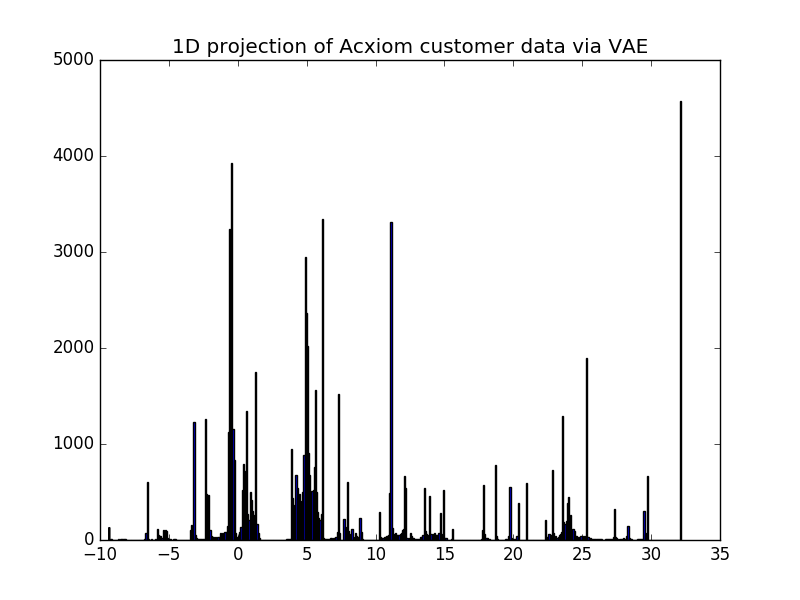

In [11]:
plt.clf()
plt.title('1D projection of Acxiom customer data via VAE')
plt.hist(encoded_sample[:,0], bins=500)
display(plt.gcf())

In [12]:
plt.clf()
plt.title('1D projection of Acxiom customer data via VAE')
plt.hist(encoded_sample[:,1], bins=100)
display(plt.gcf())

--------------------------------------------------------------------------- 
 IndexError Traceback (most recent call last)
 <command-1202464> in <module> () 
 1 plt . clf ( ) 
 2 plt . title ( '1D projection of Acxiom customer data via VAE' ) 
 ----> 3 plt . hist ( encoded_sample [ : , 1 ] , bins = 100 ) 
 4 display ( plt . gcf ( ) ) 

 IndexError : index 1 is out of bounds for axis 1 with size 1

In [13]:
decoded_sample = pickled_model.decode(encoded_sample)
decoded_sample.shape

/tmp/1538070765628-0/PythonShell.py:294: RuntimeWarning: overflow encountered in exp
 def cancel(self, expectedJobGroup):
 Out[ 37 ]: (81146, 493)

In [14]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

encoded_x_sample = encoded_sample[:,0].reshape(-1,1)
dencoded_y_sample = decoded_sample[:,0].reshape(-1,1)

for i in range(10, 50):
  z_train, z_test, x_train, x_test = train_test_split(encoded_x_sample, dencoded_y_sample, test_size=0.4)
  gmm = GaussianMixture(i).fit(z_train)
  bic = gmm.bic(z_test)
  labels = gmm.predict(z_test)
  ss = silhouette_score(x_test, labels)
  print(i, bic, ss)

10 169814.631403283 0.35346921735155895
11 168230.64708702313 0.2859982391769125
12 166127.47515171467 0.3205820647145118
13 165945.7592431185 0.31932539547241406
14 162489.9409957651 0.34532051555849985
15 163588.39736371854 0.1791531500358305
16 146622.97336812405 0.2635625611171456
17 161254.9387022793 0.3138592780749614
18 158666.38133764602 0.40359128274422734
19 153903.845700506 0.367401497521079
20 138565.64718741048 0.2337919519911557
21 149758.03473567578 0.33783680860625387
22 150606.84898423904 0.3769716178359536
23 141254.47062250177 0.4216266785390457
24 136586.59535842235 0.4393252047666717
25 145694.47891231166 0.42014155015879323
26 133500.01217523843 0.46250850340009325
27 131438.4941043795 0.4070118615153668
28 131440.76420460732 0.4637340897513616
29 134203.86782168417 0.23419941715979137
30 134106.90759131717 0.11811509545269035
31 124796.38952153984 0.2328476997526726
32 122951.04679988792 0.29839460827401315
33 117589.4044720991 0.2599342590512594
34 121066.70690564754 0.22402704819473562
35 120513.07031114957 0.44712503424597827
36 121857.6751043509 0.15579033833673528
37 119287.18637656758 0.2262699676823379
38 115216.92698508759 0.292087640413152
39 105530.62314476138 0.13660160562365473
40 109631.25825995763 0.16049137040672948
41 112707.27546844447 0.017795803456085415
42 110835.55896505876 0.2043686438517292
43 113993.22758175679 0.20032692318731443
44 106471.96068511628 0.06781200489253017
45 107368.5689006108 0.14875657680150195
46 108757.78209539125 0.22698500307624828
47 107781.60232121074 0.14876634065554198
48 106558.52015031918 0.22063774494404823
49 107419.81291796482 0.18400810596240555

In [15]:
final_gmm = GaussianMixture(28).fit(encoded_sample)

In [16]:
label_with_cluster = lambda v: (final_gmm.predict(pickled_model.project(v))[0], v)

labeled_vecs = assembler.transform(acxiom_df).rdd.map(lambda r: r.features.toArray()).map(label_with_cluster).persist()

In [17]:
from pyspark.mllib.stat import Statistics

cs = Statistics.colStats(labeled_vecs.values())

In [18]:
clusters = labeled_vecs.keys().distinct().collect()

In [19]:
labeled_vecs.countByKey()

In [20]:
from collections import defaultdict
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler

cluster_udf = F.udf(lambda v: final_gmm.predict(pickled_model.encode(v.toArray())[0])[0], T.IntegerType())

labeled_vec = 

assembler = VectorAssembler(inputCols=all_columns_without_cid, outputCol='features')
acxiom_results = assembler.transform(acxiom_df)
acxiom_results = acxiom_results.withColumn('cluster', cluster_udf(acxiom_results.features)).persist()

clusters = acxiom_results.select(acxiom_results.cluster).distinct().rdd.map(lambda r: r.cluster).collect()

total_descr = acxiom_results.describe(all_columns_without_cid).collect()
means = np.array([r[c] for c in all_columns_without_cid for r in total_descr if r.summary == 'mean'])
stddevs = np.array([r[c] for c in all_columns_without_cid for r in total_descr if r.summary == 'stddev'])

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-1201755> in <module> () 
 13 acxiom_results = acxiom_results . withColumn ( 'cluster' , cluster_udf ( acxiom_results . features ) ) . persist ( ) 
 14 
 ---> 15 clusters = acxiom_results . select ( acxiom_results . cluster ) . distinct ( ) . rdd . map ( lambda r : r . cluster ) . collect ( ) 
 16 
 17 total_descr = acxiom_results . describe ( all_columns_without_cid ) . collect ( ) 

 /databricks/spark/python/pyspark/rdd.py in collect (self) 
 822 """
 823 with SCCallSiteSync ( self . context ) as css : 
 --> 824 port = self . ctx . _jvm . PythonRDD . collectAndServe ( self . _jrdd . rdd ( ) ) 
 825 return list ( _load_from_socket ( port , self . _jrdd_deserializer ) ) 
 826 

 /databricks/spark/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1158 answer = self . gateway_client . send_command ( command ) 
 1159 return_value = get_return_value(
 -> 1160 answer, self.gateway_client, self.target_id, self.name)
 1161 
 1162 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 61 def deco ( * a , ** kw ) : 
 62 try : 
 ---> 63 return f ( * a , ** kw ) 
 64 except py4j . protocol . Py4JJavaError as e : 
 65 s = e . java_exception . toString ( ) 

 /databricks/spark/python/lib/py4j-0.10.6-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 318 raise Py4JJavaError(
 319 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 320 format(target_id, ".", name), value)
 321 else : 
 322 raise Py4JError(

 Py4JJavaError : An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 32.0 failed 4 times, most recent failure: Lost task 15.3 in stage 32.0 (TID 200, 10.239.234.93, executor 6): ExecutorLostFailure (executor 6 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1738)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1726)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1725)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1725)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:963)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:963)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:963)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1961)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1909)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1897)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:760)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2147)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2166)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2191)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:951)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$

In [21]:
df_test = assembler.transform(acxiom_df).rdd.map(lambda r: pickled_model.encode(r.features)).persist()
df_test.take(2)

In [22]:
results = []
for i in clusters:
  df = acxiom_results.where(acxiom_results.cluster == i)
  cluster_descr = df.describe(all_columns_without_cid).collect()
  cluster_means = np.array([r[c] for c in all_columns_without_cid for r in cluster_descr if r.summary == 'mean'])
  cluster_stddevs = np.array([r[c] for c in all_columns_without_cid for r in cluster_descr if r.summary == 'stddev'])
  
  kl_dev = np.log(cluster_stddevs / stddevs) + (((stddevs**2 - cluster_stddevs**2) + (means - cluster_means)**2) / (2 * cluster_stddevs**2))
  
  results.extend([(i, c, kl, c_mu, c_sig, c_mu - mu, c_sig - sig) for c, kl, c_mu, c_sig, mu, sig in 
                  zip(all_columns_without_cid, kl_dev, cluster_means, cluster_stddevs, means, stddevs)])

results_df = spark.createDataFrame(results, ['cluster', 'field', 'kl_divergence', ''])

In [23]:
display(results_df)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1201382> in <module> () 
 ----> 1 display ( results_df ) 

 NameError : name 'results_df' is not defined